# Calibrate Cameras
[https://docs.opencv.org/3.4/d9/dab/tutorial_homography.html](https://docs.opencv.org/3.4/d9/dab/tutorial_homography.html)

In [35]:
from models.dataset.dataset_container import DatasetContainer
from matplotlib import pyplot as plt
from pathlib import Path
import cv2

In [36]:
resource_path = Path("../../resources")

## Actual Calibration

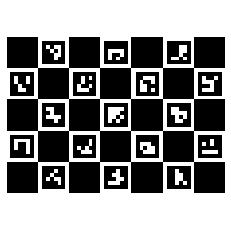

In [37]:
import matplotlib as mpl
# dataset_container = DatasetContainer()
# dataset_container.load_from_dataset(args.uncalibrated_dataset_path)
# 
# print(f"Opened dataset containing {dataset_container.size()} image sets")

# charuco board configuration
charuco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50) 
charuco_board = cv2.aruco.CharucoBoard_create(7, 5, 7.5, 5.625, charuco_dict)
# charuco_board = cv2.aruco.CharucoBoard_create(5, 3, 4.5, 3.375, charuco_dict)

# print board layout
imboard = charuco_board.draw((500, 500))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
ax.axis("off")
plt.show()


# Load images from multiple datasets

In [38]:
# Combine Multiple Datasets to average calibration on
dataset_container = DatasetContainer()
dataset_container.load_from_dataset(resource_path / Path("images/uncalibrated/c_dataset_d_1.npz"))
dataset_container_tmp = DatasetContainer()
# dataset_container_tmp.load_from_dataset(resource_path / Path("images/uncalibrated/c_dataset_small_near_2.npz"))
# dataset_container.extend(dataset_container_tmp)
# dataset_container_tmp.load_from_dataset(resource_path / Path("images/uncalibrated/c_dataset_d_1.npz"))
# dataset_container.extend(dataset_container_tmp)
# dataset_container_tmp.load_from_dataset(resource_path / Path("images/uncalibrated/c_dataset_h_2.npz"))
# dataset_container.extend(dataset_container_tmp)

In [39]:
imgs_1_points = []
imgs_2_points = []
imgs_1 = dataset_container.realsense.rgb[:1]
imgs_2 = dataset_container.zivid.rgb[:1]
common_points_threshold = 20
silent = False
import numpy as np

assert len(imgs_1) == len(imgs_2) > 0

# Reference: https://stackoverflow.com/questions/64612924/opencv-stereocalibration-of-two-cameras-using-charuco
obj_points = []

img_1_size = tuple(reversed(imgs_1[0].shape[:2]))
img_2_size = tuple(reversed(imgs_2[0].shape[:2]))

imgs_1_debug = []
imgs_2_debug = []

for img_1_bgr, img_2_bgr in zip(imgs_1, imgs_2):
    try:
        # convert BGR to Gray
        img_1 = cv2.cvtColor(img_1_bgr, cv2.COLOR_BGR2GRAY)
        img_2 = cv2.cvtColor(img_2_bgr, cv2.COLOR_BGR2GRAY)

        # Find markers corners
        img_1_corners, img_1_ids, _ = cv2.aruco.detectMarkers(
            img_1, charuco_dict)
        img_2_corners, img_2_ids, _ = cv2.aruco.detectMarkers(
            img_2, charuco_dict)
        if not img_1_corners or not img_2_corners:
            raise Exception("No markers detected")

        # find charcuo corners # TODO: try with cameraMatrix/distCoeffs
        retA, img_1_corners, img_1_ids = cv2.aruco.interpolateCornersCharuco(
            img_1_corners, img_1_ids, img_1, charuco_board)
        retB, img_2_corners, img_2_ids = cv2.aruco.interpolateCornersCharuco(
            img_2_corners, img_2_ids, img_2, charuco_board)
        if not retA or not retB:
            raise Exception("Can't interpolate corners")

        imgs_1_debug.append(cv2.aruco.drawDetectedCornersCharuco(img_1_bgr, img_1_corners, img_1_ids, [0, 1, 0]))

        # Find common points in both frames (is there a nicer way?)
        obj_points_1, img_1_points = cv2.aruco.getBoardObjectAndImagePoints(
            charuco_board, img_1_corners, img_1_ids)
        obj_points_2, img_2_points = cv2.aruco.getBoardObjectAndImagePoints(
            charuco_board, img_2_corners, img_2_ids)

        # Create dictionary for each frame objectPoint:imagePoint to get common markers detected
        img_1_obj_to_points = {
            tuple(a): tuple(b)
            for a, b in zip(obj_points_1[:, 0], img_1_points[:, 0])
        }
        img_2_obj_to_points = {
            tuple(a): tuple(b)
            for a, b in zip(obj_points_2[:, 0], img_2_points[:, 0])
        }
        common = set(img_1_obj_to_points.keys())\
                & set(img_2_obj_to_points.keys())

        if len(common) < common_points_threshold:
            raise Exception(
                f"To few respective points found in images ({len(common)})"
            )

        # fill arrays where each index specifies one markers objectPoint and both
        # respective imagePoints
        img_common_obj_points = []
        img_1_points = []
        img_2_common_frame_points = []
        for objP in common:
            img_common_obj_points.append(np.array(objP))
            img_1_points.append(np.array(img_1_obj_to_points[objP]))
            img_2_common_frame_points.append(
                np.array(img_2_obj_to_points[objP]))
        imgs_1_points.append(np.array(img_1_points))
        imgs_2_points.append(np.array(img_2_common_frame_points))
        obj_points.append(np.array(img_common_obj_points))

    except Exception as e:
        if not silent:
            print(f"Skipped frame: {e}")
        continue
imgs_1_points = [img_point for img_points in imgs_1_points for img_point in img_points]
imgs_2_points = [img_point for img_points in imgs_2_points for img_point in img_points]
imgs_1_points = np.reshape(imgs_1_points, (-1, 2))
imgs_2_points = np.reshape(imgs_2_points, (-1, 2))

H, _ = cv2.findHomography(imgs_1_points, imgs_2_points)


True

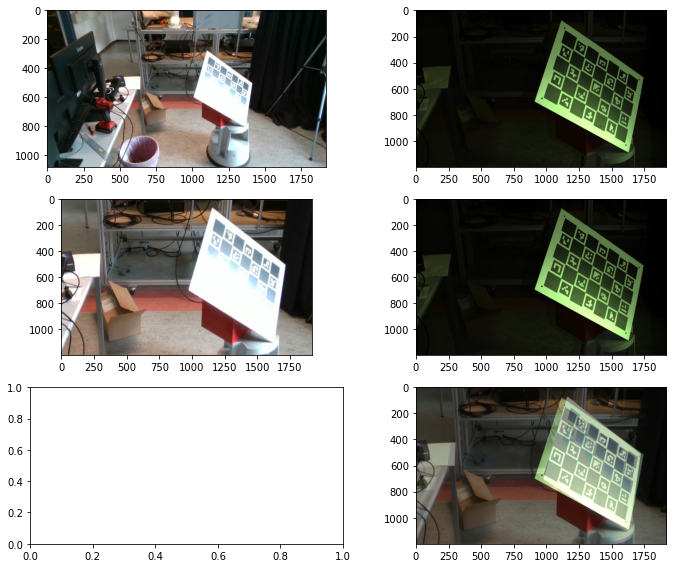

In [52]:
idx = 5
# img_1 = imgs_1_debug[idx]
# img_2 = imgs_2[idx]
img_1 = dataset_container.realsense.rgb[idx]
img_2 = dataset_container.zivid.rgb[idx]

# H = np.loadtxt(resource_path / Path("calibrations/regression/calibration_from_all.np"))

img_1_warp = cv2.warpPerspective(img_1, H, (img_2.shape[1], img_2.shape[0]))
img_both = cv2.addWeighted(img_1_warp, 0.5, img_2, 0.7, 0)

f, axarr = plt.subplots(3, 2, figsize=(10, 8))
f.tight_layout()
axarr[0][0].imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))
axarr[0][1].imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))
axarr[1][0].imshow(cv2.cvtColor(img_1_warp, cv2.COLOR_BGR2RGB))
axarr[1][1].imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))
axarr[2][1].imshow(cv2.cvtColor(img_both, cv2.COLOR_BGR2RGB))
cv2.imwrite("test.png", img_both)

In [13]:
np.savetxt("../../resources/calibrations/regression/.np", H)